In [1]:
!pip install netCDF4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/GEO_AQ_GEMS

Mounted at /content/drive
/content/drive/MyDrive/GEO_AQ_GEMS


In [3]:
import numpy as np
import datetime as dt
import glob
import netCDF4 as nc4

import matplotlib.pyplot as plt
from matplotlib import gridspec ; import matplotlib.pyplot as plt
import matplotlib.ticker as mtick ; import matplotlib.colors as colors
import matplotlib.dates as mdates

def Haversine_distance(lat1, lon1, lat2, lon2):
    d_lat = np.deg2rad(abs(lat1-lat2))
    d_lon = np.deg2rad(abs(lon1-lon2))
    a = np.sin(d_lat/2)**2+np.cos(np.deg2rad(lat1))*np.cos(np.deg2rad(lat2))*np.sin(d_lon/2)**2
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return 6378206.4 * c / 1000



# file setting
date = dt.datetime(2022,8,12) # year, month, day
n_hour = 24

# figure setting
AOD_channel = 1  # 0: 354nm, 1: 443nm, 2: 550nm
vlim = (0,1)

#-----------------
# Read AERONET
#-----------------
lev15files = glob.glob('*.lev15')

file_r = open(lev15files[0],'r',encoding='latin1')
for i in range(6): file_r.readline()
log_line = file_r.readline()
log = log_line.strip().split(',')

idx_lon  = log.index('Site_Longitude(Degrees)')
idx_lat  = log.index('Site_Latitude(Degrees)')
idx_site = log.index('AERONET_Site_Name')
idx_date = log.index('Date(dd:mm:yyyy)')
idx_time = log.index('Time(hh:mm:ss)')
idx_aod  = log.index('AOD_440nm')

lines = file_r.readlines()
temp = lines[0].strip().split(',')

a_lat = float(temp[idx_lat])
a_lon = float(temp[idx_lon])
a_site = temp[idx_site]

a_date = np.full(len(lines), dt.datetime(1000,1,1), dtype=dt.datetime)
a_aod = np.full(len(lines), np.nan)

for l in range(len(lines)):
    temp = lines[l].strip().split(',')
    a_date[l] = dt.datetime.strptime(temp[idx_date]+temp[idx_time], '%d:%m:%Y%H:%M:%S')
    a_aod[l] = float(temp[idx_aod])

a_aod[np.where(a_aod == -999)] = np.nan

#-----------------
# Read GEMS
#-----------------
g_date = np.full(n_hour, dt.datetime(1000,1,1), dtype=dt.datetime)
g_aod = np.full(n_hour, np.nan)

for hh in range(n_hour):

    GEMS_date = date + dt.timedelta(hours=hh)
    gemsfiles = glob.glob(GEMS_date.strftime('GK2_GEMS_L2_%Y%m%d_%H*_*.nc'))

    if gemsfiles!=[]:
        NC = nc4.Dataset(gemsfiles[0])

        lat = NC.groups['Geolocation Fields'].variables['Latitude']
        fillvalue = lat._FillValue
        lat = np.array(lat); lat[lat == fillvalue] = np.nan
        
        lon = NC.groups['Geolocation Fields'].variables['Longitude']
        fillvalue = lon._FillValue
        lon = np.array(lon); lon[lon == fillvalue] = np.nan
        
        AOD = NC.groups['Data Fields'].variables['FinalAerosolOpticalDepth']
        fillvalue = AOD._FillValue
        AOD = np.array(AOD); AOD[AOD == fillvalue] = np.nan
        AOD = AOD[AOD_channel,:,:]

        # find GEMS pixel closest to AERONET Site
        distances = Haversine_distance(a_lat,a_lon,lat,lon)
        idx = np.where(distances == np.nanmin(distances))

        g_aod[hh]=AOD[idx]
        g_date[hh]=date+dt.timedelta(hours=hh)+dt.timedelta(minutes=45)



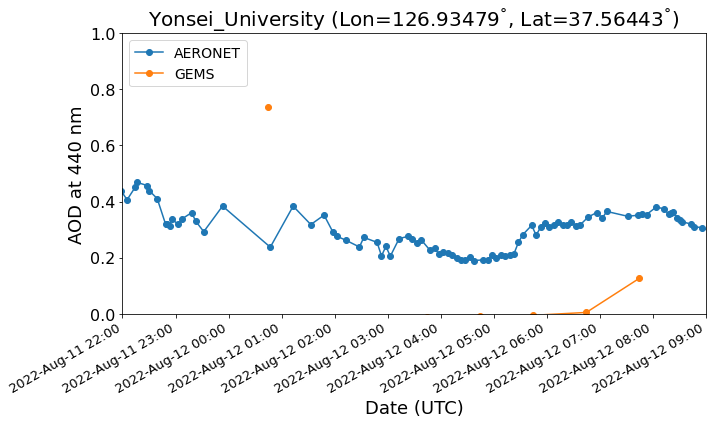

In [4]:
# figure size
fig, ax = plt.subplots(figsize=(10,6))

# title, label
ax.set_title('{} (Lon={}$^\degree$, Lat={}$^\degree$)'.format(a_site,a_lon,a_lat), fontsize=20)
ax.set_xlabel("Date (UTC)", fontsize=18)
ax.set_ylabel("AOD at 440 nm", fontsize=18)

# limit
ax.set_ylim(vlim[0], vlim[1])
ax.set_xlim(date-dt.timedelta(hours=2), date+dt.timedelta(hours=9))

# define x-axis format
hour_locator = mdates.HourLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%b-%d %H:%M") # four digits for year, two for month

ax.tick_params(axis = 'x', labelsize =13)
ax.tick_params(axis = 'y', labelsize =16)

ax.xaxis.set_major_locator(hour_locator)
ax.xaxis.set_major_formatter(year_month_formatter) # formatter for major axis only

# Rotates and right aligns the x labels.
# Also moves the bottom of the axes up to make room for them.
fig.autofmt_xdate()

# output
ax.plot(a_date,a_aod,marker="o",label='AERONET')
ax.plot(g_date,g_aod,marker="o",label='GEMS')
ax.legend(loc='upper left',fontsize=14)

plt.tight_layout()

plt.savefig('Time_series_GEMS_AOD550nm_{}.png'.format(date.strftime('%Y%m%d')), dpi=300)